# Prerequisite
* Load required packages and load images (already uploaded on  Blackboard) in Colab
* Create your own copy of notebook and add required code snippets in between the questions subsections. Also display the figures at each stage.

*Colab can be exported as a notebook file or Python file by **File > Download .ipynb** or **File > Download .py**. Exported notebook files can be reloaded into Google Colab or used in Jupyter Notebook.
* Please go through [Colab document](https://colab.research.google.com/drive/1YKHHLSlG-B9Ez2-zf-YFxXTVgfC_Aqtt) for further information.

* **Use ONLY following numpy and tensorflow/pytorch functions for any operations**

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import tensorflow as tf

#Q1) Laplacian-of-Gaussian of bld.tif
 Assume the pixel dimensions to be equal along both axes, i.e., assume an aspect ratio of 1:1 for the axes.

Data_type is {} float32
Image Size is (600, 600)
Image min and max are (0.0, 255.0)


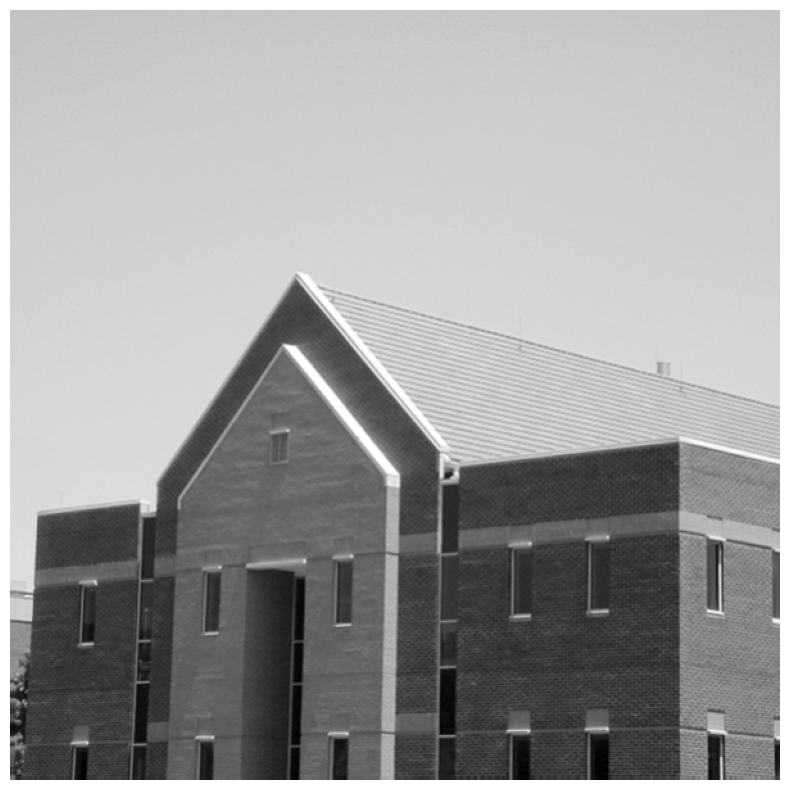

In [2]:
img =  cv.imread('bld.tif', cv.IMREAD_GRAYSCALE)
kernel_sz1 = np.ones(1)
## Change Data type of image ####################
img = cv.filter2D(img, cv.CV_32F, kernel_sz1)
#################################################
print('Data_type is {}', img.dtype)
print('Image Size is {}'.format(img.shape))
print('Image min and max are ({}, {})'.format(img.min(),img.max()))
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Now write a python-tensorflow based function to implement LoG operator. Apply that function to $img$ to get LoG output.
[hint: scale image to lie in $[0,1]$ and rescale back before displaying]


In [9]:
scaledImg = (img - img.min()) / (img.max() - img.min())
scaledImg.max()

gaussianFilter = 0

def LoG(img, kernelSize=5, sigma=1.0):
    x = tf.range(-kernelSize // 2 + 1, kernelSize // 2 + 1, dtype=tf.float32)
    y = tf.range(-kernelSize // 2 + 1, kernelSize // 2 + 1, dtype=tf.float32)
    x, y = tf.meshgrid(x, y)
    gaussianKernel = tf.exp(-(x**2 + y**2) / (2.0 * sigma**2))
    gaussianKernel /= tf.reduce_sum(gaussianKernel) #normalized the kernel
    gaussianFilter = gaussianKernel.numpy() #For later use
    
    print('Gaussian kernel:', gaussianKernel.shape)

    #Laplacian kernel
    lapKernel = tf.constant([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=tf.float32)

    img = tf.reshape(img, [1, img.shape[0], img.shape[1], 1])
    gaussianKernel = tf.reshape(gaussianKernel, [kernelSize, kernelSize, 1, 1])
    lapKernel = tf.reshape(lapKernel, [3, 3, 1, 1])

    #Applying Gaussian Blur
    gaussian_blurred = tf.nn.conv2d(
        img, gaussianKernel, strides=[1, 1, 1, 1], padding='SAME'
    )

    #Applying Laplacian on Gaussian Blurred Image
    imgLoG = tf.nn.conv2d(
        gaussian_blurred, lapKernel, strides=[1, 1, 1, 1], padding='SAME'
    )
    imgLoG = tf.squeeze(imgLoG, axis=0)
    return imgLoG, gaussianKernel

##(a)[**4 Points**] Print LoG output from previous function

Gaussian kernel: (10, 10)
Using Gaussian kernel of size 5 and sigma 1.0
LoG Image min and max are (0.0, 255.0)


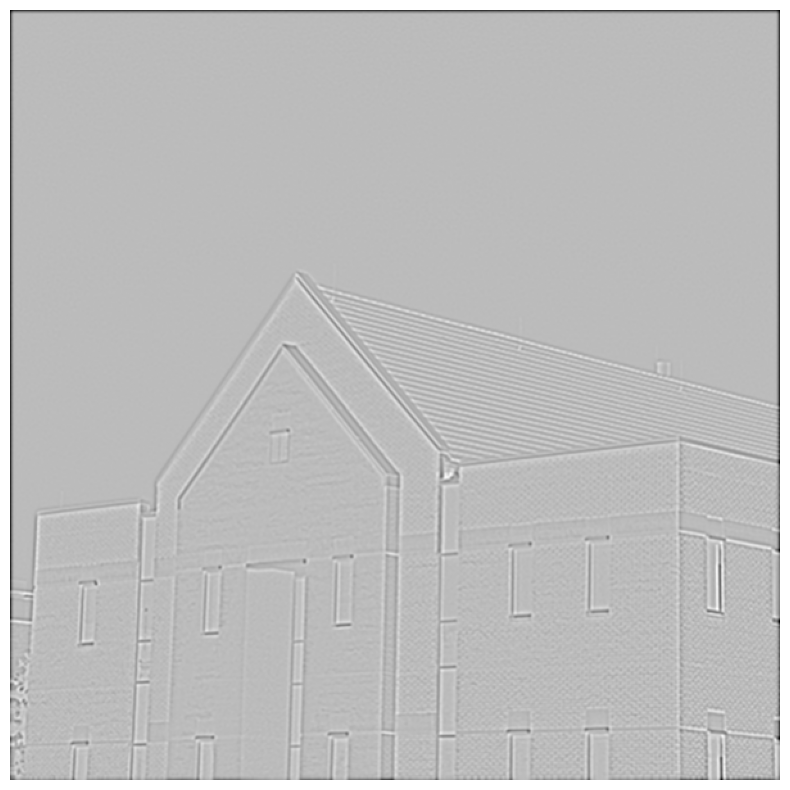

In [10]:
imgLoG,kernel = LoG(scaledImg, 10, 1.0)

print("Using Gaussian kernel of size 5 and sigma 1.0")

imgLoG_normalized = 255*(imgLoG - imgLoG.numpy().min()) / (imgLoG.numpy().max() - imgLoG.numpy().min())
imgLoG = imgLoG_normalized.numpy()
print('LoG Image min and max are ({}, {})'.format(imgLoG.min(), imgLoG.max()))
plt.figure(figsize=(10,10))
plt.imshow(imgLoG, cmap='gray')
plt.axis('off')
plt.show()


##(b)[**2 Points**]Theshold the zero-crossing of LoG output to remove unwanted edges. Display that output.

187.23218


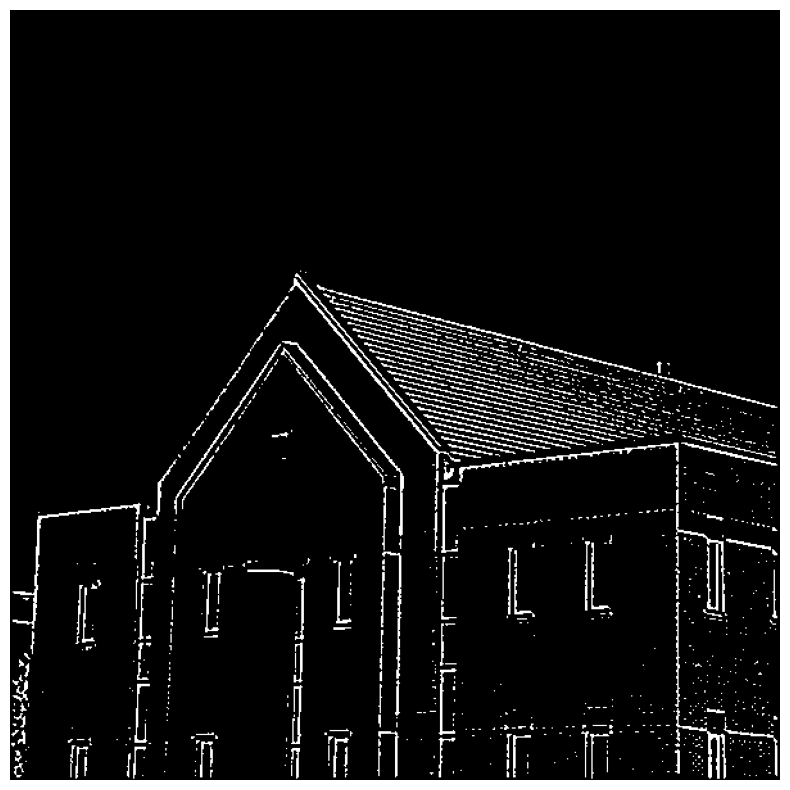

In [11]:
print(np.median(imgLoG))
imgLoG[imgLoG < 199] = 0
imgLoG[imgLoG > 0] = 1
plt.figure(figsize=(10,10))
plt.imshow(imgLoG, cmap='gray')
plt.axis('off')
plt.show()  

##(c)[**4 Points**] implement Canny Edge operator from scratch using tensorflow-python without any for-loops. Display the final Canny edge detector output on $img$. Tune the required parameters to get best output.

In [12]:
kernel = tf.reshape(kernel, [kernel.shape[0], kernel.shape[1]])
tf.shape(kernel)
kernel = kernel.numpy()
print('Kernel Shape:', kernel.shape)

Kernel Shape: (10, 10)


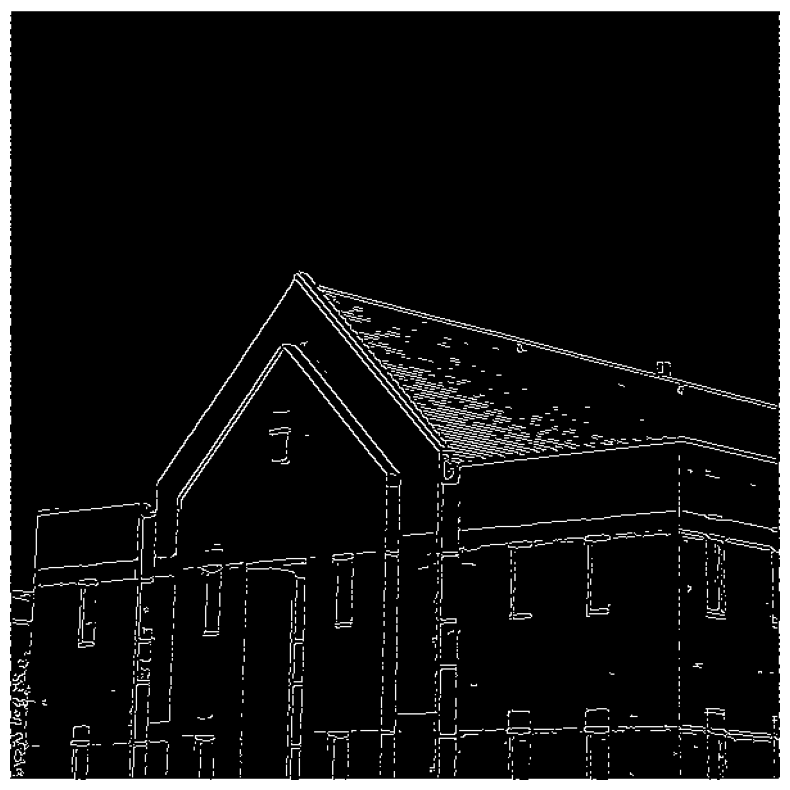

In [15]:
def detect_edges(imgInp, thresholdMin, thesholdMax):
    filterWeights = kernel
    imgNorm = tf.convert_to_tensor(imgInp / 255.0, dtype=tf.float32)
    expanded_img = imgNorm[tf.newaxis, ..., tf.newaxis]
    
    filterReshaped = filterWeights[:, :, tf.newaxis, tf.newaxis]
    smoothed_img = tf.nn.conv2d(expanded_img, filterReshaped, strides=1, padding='SAME')
    
    
    
    h = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)[:, :, tf.newaxis, tf.newaxis]
    v = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)[:, :, tf.newaxis, tf.newaxis]
    
    
    dx = tf.nn.conv2d(smoothed_img, h, strides=1, padding='SAME')
    dy = tf.nn.conv2d(smoothed_img, v, strides=1, padding='SAME')
    
    m = tf.sqrt(dx**2 + dy**2)
    theta = tf.atan2(dy, dx) * (180 / np.pi)
    theta = theta % 180

    mPad = tf.pad(m, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
    thetaQuantized = tf.round(theta / 45) * 45
    
    cond_0 = tf.logical_and(
        mPad[:, 1:-1, 1:-1, :] >= mPad[:, 1:-1, :-2, :],
        mPad[:, 1:-1, 1:-1, :] >= mPad[:, 1:-1, 2:, :]
    )
    cond_45 = tf.logical_and(
        mPad[:, 1:-1, 1:-1, :] >= mPad[:, :-2, :-2, :],
        mPad[:, 1:-1, 1:-1, :] >= mPad[:, 2:, 2:, :]
    )
    cond_90 = tf.logical_and(
        mPad[:, 1:-1, 1:-1, :] >= mPad[:, :-2, 1:-1, :],
        mPad[:, 1:-1, 1:-1, :] >= mPad[:, 2:, 1:-1, :]
    )
    cond_135 = tf.logical_and(
        mPad[:, 1:-1, 1:-1, :] >= mPad[:, :-2, 2:, :],
        mPad[:, 1:-1, 1:-1, :] >= mPad[:, 2:, :-2, :]
    )
    
    nms_mask = tf.logical_or(
        tf.logical_or(
            tf.logical_and(tf.equal(thetaQuantized, 0), cond_0),
            tf.logical_and(tf.equal(thetaQuantized, 45), cond_45)
        ),
        tf.logical_or(
            tf.logical_and(tf.equal(thetaQuantized, 90), cond_90),
            tf.logical_and(tf.equal(thetaQuantized, 135), cond_135)
        )
    )
    
    thinnedMag = tf.where(nms_mask, m, tf.zeros_like(m))
    
    strong = thinnedMag > thesholdMax
    weak = tf.logical_and(thinnedMag > thresholdMin, thinnedMag <= thesholdMax)
    expanded_strong = tf.nn.max_pool2d(tf.cast(strong, tf.float32), 3, 1, 'SAME') > 0
    detected_edges = tf.logical_or(strong, tf.logical_and(weak, expanded_strong))
    
    edges = tf.cast(detected_edges, tf.float32) * 255.0
    return tf.squeeze(edges).numpy()

canny_result = detect_edges(img,0.001,0.2)
plt.figure(figsize=(10,10))
plt.imshow(canny_result, cmap='gray')
plt.axis('off')
plt.show()